# Dataset construction

In [2]:
import torch 
import numpy as np
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import load_model
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib.gridspec import GridSpec
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
from os.path import join
import pickle
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, auc
from sklearn.preprocessing import label_binarize

np.random.seed(1328)
torch.random.manual_seed(1328)

In [56]:

#FUNZIONE PER CARICARE IL DATASET DI IMMAGINI

def load_images_from_subfolders(main_folder):
    data = []
    label_names = {}
    label_index = 0
    alphabet = [chr(i) for i in range(ord('a'), ord('z') + 1) if chr(i) != 'j']  # List of characters excluding 'j'
    
    # Loop through each subject folder
    for subject_folder in os.listdir(main_folder):
        subject_path = os.path.join(main_folder, subject_folder)
        if os.path.isdir(subject_path):
            # Loop through each letter subfolder
            for letter_folder in os.listdir(subject_path):
                letter_path = os.path.join(subject_path, letter_folder)
                if os.path.isdir(letter_path):
                    # Get or create a label index for the letter
                    if letter_folder not in label_names:
                        label_names[letter_folder] = label_index
                        label_index += 1
                    label = label_names[letter_folder]
                    
                    # Load each image in the letter subfolder
                    for filename in os.listdir(letter_path):
                        img = cv2.imread(os.path.join(letter_path, filename), cv2.IMREAD_GRAYSCALE)
                        if img is not None:
                            img = cv2.resize(img, (100, 100)) 
                            data.append({'image': img, 'label': label, 'letter': letter_folder})
    
    return pd.DataFrame(data), label_names, alphabet

def prepare_data(df):
    # Expand the dimensions of images to add the channel dimension
    df['image'] = df['image'].apply(lambda x: x[:, :, np.newaxis])
    
    # Convert labels to one-hot encoding
    labels = to_categorical(df['label'], num_classes=df['label'].nunique())
    df['label'] = list(labels)
    
    return df

#CREAZIONE TEST E TRAIN SET
def create_train_test_dataframe(df, test_size=0.2):
    # Split the dataset into training and testing sets
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=42, stratify=df['label'].apply(lambda x: np.argmax(x)))
    
    print(f"Train set: {df_train.shape}, Test set: {df_test.shape}")
    
    return df_train, df_test

#PLOT CLASS DISTRIBUITION
def plot_class_distribution(df, title, alphabet):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(15, 6))
    label_indices = df['label'].apply(lambda x: np.argmax(x))  # Get the original class indices
    label_counts = label_indices.value_counts().reindex(range(len(alphabet)), fill_value=0)
    
    ax = sns.barplot(x=alphabet, y=label_counts.values, palette="pastel", legend=False)
    ax.set_title(f"Distribution of Samples in {title} Data", fontsize=16, fontweight='bold')
    ax.set_xlabel("Class", fontsize=14)
    ax.set_ylabel("Number of Samples", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(f'plots/distribution_{title}_data.png')

    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)
    plt.show()

#per plottare alcune immagini di esempio
def plot_sample_images(df_train, alphabet):
    fig = plt.figure(figsize=(9, 9))
    gs = GridSpec(3, 3, figure=fig)  # Griglia 3x3

    # Convert one-hot encoded labels back to integers for uniqueness
    df_train['label_int'] = df_train['label'].apply(lambda x: np.argmax(x))
    unique_labels = df_train['label_int'].unique()[:3]  # Limita a 3 categorie

    for i, category in enumerate(unique_labels):
        sample_images = df_train[df_train['label_int'] == category].sample(min(3, len(df_train[df_train['label_int'] == category])))
        for j, (index, row) in enumerate(sample_images.iterrows()):
            ax = fig.add_subplot(gs[i, j])
            img = row['image'].reshape(100, 100)  # Assuming the images are 64x64
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            if j == 0:
                ax.text(0.5, -0.1, alphabet[category], fontsize=25, color='black', ha='center', transform=ax.transAxes)
    plt.show()

In [57]:
main_folder = 'dataset'
df, label_names, alphabet = load_images_from_subfolders(main_folder)
df = prepare_data(df)
df_train, df_test = create_train_test_dataframe(df)

Train set: (2797, 3), Test set: (700, 3)


C:\Users\orazi\AppData\Local\Temp\ipykernel_22884\302366306.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=alphabet, y=label_counts.values, palette="pastel", legend=False)


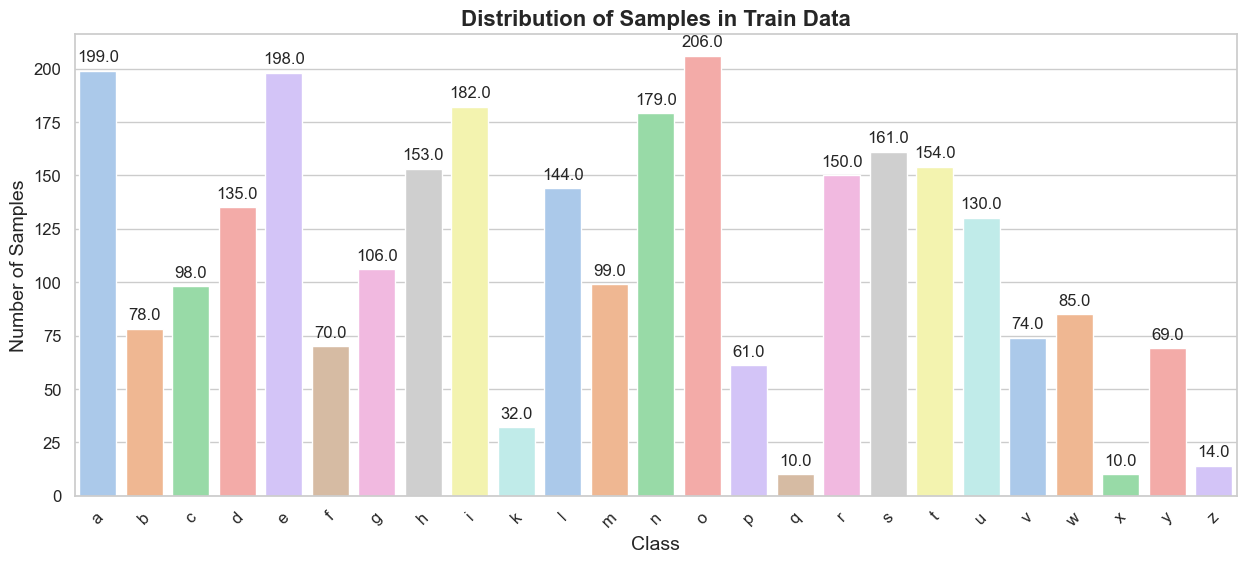

C:\Users\orazi\AppData\Local\Temp\ipykernel_22884\302366306.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=alphabet, y=label_counts.values, palette="pastel", legend=False)


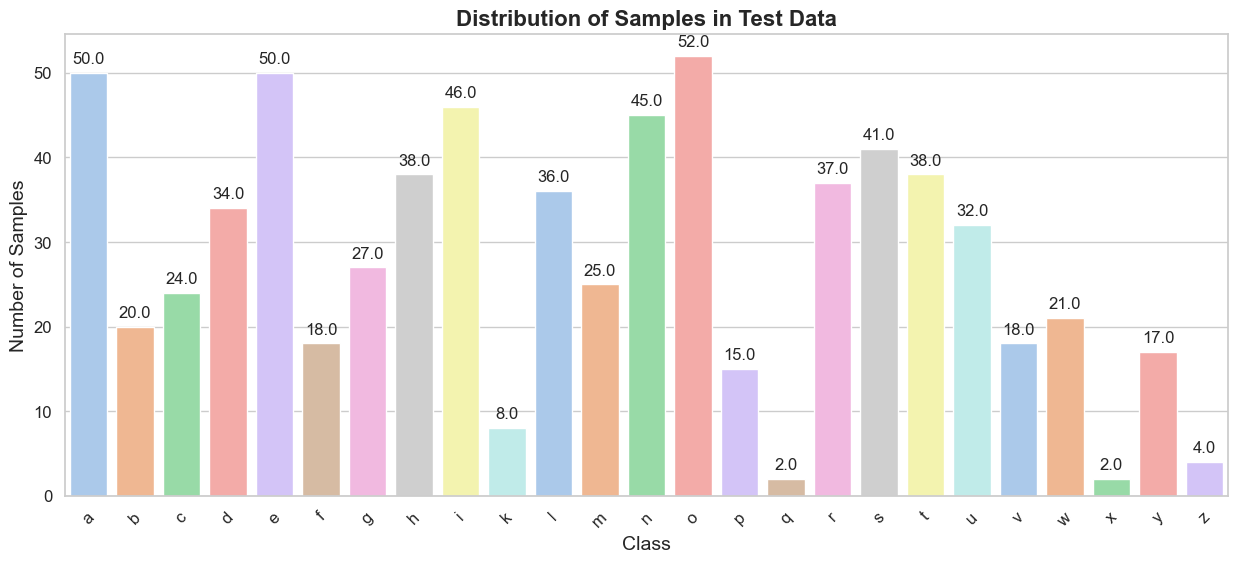

In [58]:
plot_class_distribution(df_train, 'Train', alphabet)
plot_class_distribution(df_test, 'Test', alphabet)

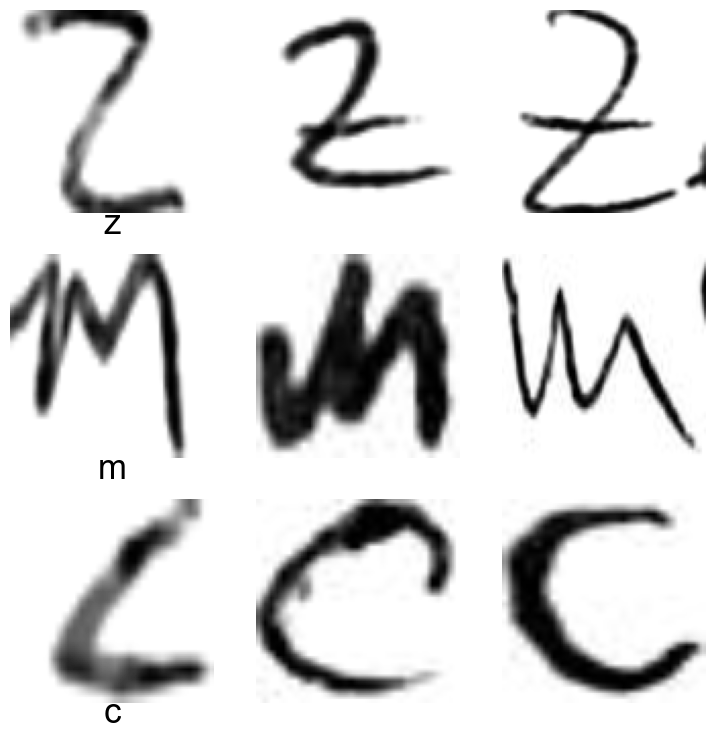

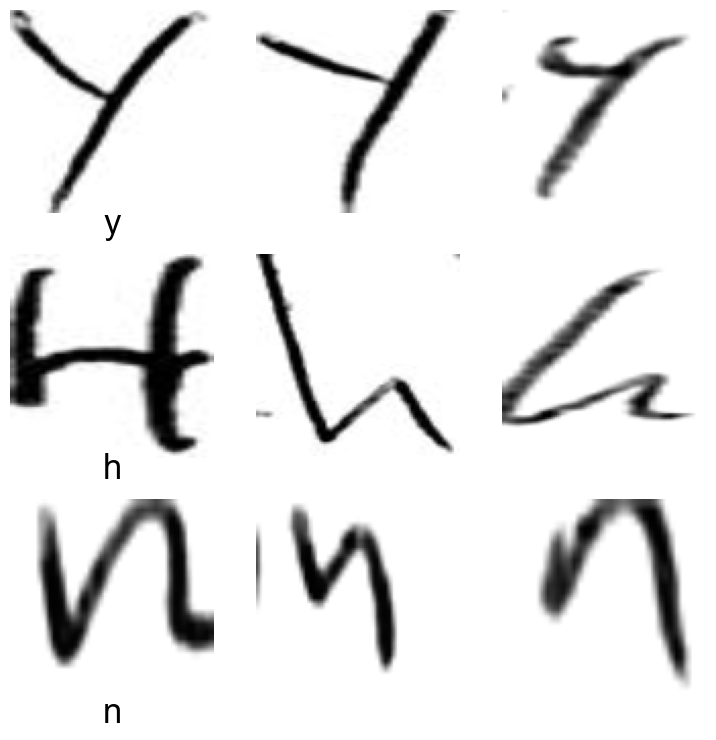

In [59]:
# Example usage
plot_sample_images(df_train, alphabet)
plot_sample_images(df_test, alphabet)

In [60]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None, augment=False):
        self.transform = transform
        self.augment = augment
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(dataframe['label_int'].unique())}
        if self.augment:
            self.dataframe = pd.concat([dataframe, dataframe]).reset_index(drop=True)
        else:
            self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_array = row['image']
        if len(image_array.shape) == 3 and image_array.shape[2] == 1:
            image_array = image_array.squeeze(-1)  # Remove the channel dimension if it's 1
        image = Image.fromarray(image_array.astype(np.uint8)).convert('RGB')  # Convert to RGB
        label = row['label_int']

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
train_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop((50, 50)), 
    transforms.RandomAffine(30),  
    transforms.Resize((50, 50)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Ensure label_int column is present
df_train['label_int'] = df_train['label'].apply(lambda x: np.argmax(x))

# Split dataset into training, testing, and validation
train_df, test_val_df = train_test_split(df_train, test_size=0.4, random_state=42)
test_df, val_df = train_test_split(test_val_df, test_size=0.5, random_state=42)

train_dataset = CustomDataset(train_df, transform=train_transform, augment=True) # Augmentation duplicates size of training dataset
val_dataset = CustomDataset(val_df, transform=val_transform)
test_dataset = CustomDataset(test_df, transform=val_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [61]:
# Training data
print(f"Training Samples ({len(train_dataset)})")
inputs, classes = next(iter(train_loader))
print("Shape:", inputs.shape)

# Validation data
print(f"Validation Samples ({len(val_dataset)})")
inputs, classes = next(iter(val_loader))
print("Shape:", inputs.shape)

# Testing data
print(f"Testing Samples ({len(test_dataset)})")
inputs, classes = next(iter(test_loader))
print("Shape:", inputs.shape)

Training Samples (3356)
Shape: torch.Size([64, 3, 50, 50])
Validation Samples (560)
Shape: torch.Size([64, 3, 50, 50])
Testing Samples (559)
Shape: torch.Size([64, 3, 50, 50])


## Letter-Classifier model

In [62]:
class AverageValueMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.sum = 0
        self.n = 0

    def add(self, value, n):
        self.sum += value * n
        self.n += n

    def value(self):
        return self.sum / self.n if self.n > 0 else 0

In [4]:

class LetterClassifier(nn.Module):
    
    def __init__(self, input_shape=(50, 50, 3), num_classes=25, dropout_rate=0.5):
        super(LetterClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # convolutional layer 1
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # convolutional layer 2
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # convolutional layer 3
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1), # convolutional layer 4
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
            
            nn.Flatten(),
            nn.Linear(256 * 3 * 3, 512), # fully connected layer
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),

            nn.Linear(512, num_classes) # output layer (fully connected)
        )

    def forward(self, x):
        return self.model(x)

    def numparams(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def train_model(self, train_loader, val_loader, exp_name='experiment', epochs=10, lr=0.001, momentum=0.9, weight_decay=1e-4, logdir='logs', verbose=True, save_model=True):
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.model.parameters(), lr, momentum=momentum, weight_decay=weight_decay)  

        train_losses = []; train_accuracies = []
        val_losses = []; val_accuracies = []

        loss_meter = AverageValueMeter()
        acc_meter = AverageValueMeter()
        writer = SummaryWriter(join(logdir, exp_name))

        device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu") # usare cuda
        self.to(device)
        loader = {'train': train_loader, 'val': val_loader}

        global_step = 0
        best_val_loss = float('inf')
        epochs_no_improve = 0  
        patience = 10
        for e in range(epochs):
            print(f'[Epoch {e+1}/{epochs}]')
            for mode in ['train', 'val']:
                loss_meter.reset()
                acc_meter.reset()
                self.model.train() if mode == 'train' else self.model.eval()

                with torch.set_grad_enabled(mode == 'train'):
                    for i, batch in enumerate(loader[mode]):
                        X = batch[0].to(device)
                        y = batch[1].to(device)
                        out = self.model(X)

                        n = X.shape[0]
                        global_step += n
                        l = loss_fn(out, y)

                        if mode == 'train':
                            l.backward()
                            optimizer.step()
                            optimizer.zero_grad()

                        loss_meter.add(l.item(), n)
                        acc = accuracy_score(y.to('cpu'), out.to('cpu').max(1)[1])
                        acc_meter.add(acc, n)

                        if mode == 'train':
                            writer.add_scalar('loss/train', loss_meter.value(), global_step=global_step)
                            writer.add_scalar('accuracy/train', acc_meter.value(), global_step=global_step)

                    writer.add_scalar('loss/'+mode, loss_meter.value(), global_step=global_step)
                    writer.add_scalar('accuracy/'+mode, acc_meter.value(), global_step=global_step)

                    if mode == 'train':
                        train_losses.append(loss_meter.value())
                        train_accuracies.append(acc_meter.value())
                    else:
                        val_losses.append(loss_meter.value())
                        val_accuracies.append(acc_meter.value())

                        if val_losses[-1] < best_val_loss:
                            best_val_loss = val_losses[-1]
                            epochs_no_improve = 0  
                            if save_model:
                                torch.save(self.model.state_dict(), os.path.join('models', f'{exp_name}.pth'))
                                with open(os.path.join('metrics', f'{exp_name}_metrics.pkl'), 'wb') as f:
                                    pickle.dump({
                                        'train_loss': train_losses, 
                                        'val_loss': val_losses,
                                        'train_accuracy': train_accuracies, 
                                        'val_accuracy': val_accuracies
                                    }, f)
                        else:
                            epochs_no_improve += 1 

            if verbose:
                print(f'Train Loss: {train_losses[-1]:.3f}, Train Accuracy: {train_accuracies[-1]:.3f} | Val Loss: {val_losses[-1]:.3f}, Val Accuracy: {val_accuracies[-1]:.3f}\n')

            if epochs_no_improve == patience:
                print('Early stopping')
                break

        return train_losses, train_accuracies, val_losses, val_accuracies

    def test_model(self, test_loader):
        self.model.eval()
        loss_fn = nn.CrossEntropyLoss()
        loss_meter = AverageValueMeter()
        acc_meter = AverageValueMeter()
        device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
        self.to(device)

        with torch.no_grad():
            for batch in test_loader:
                X = batch[0].to(device)
                y = batch[1].to(device)
                out = self.model(X)

                n = X.shape[0]
                l = loss_fn(out, y)

                loss_meter.add(l.item(), n)
                acc = accuracy_score(y.to('cpu'), out.to('cpu').max(1)[1])
                acc_meter.add(acc, n)

        test_loss = loss_meter.value()
        test_accuracy = acc_meter.value()

        return test_loss, test_accuracy

    def test_error(self, test_loader):
        device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
        self.model.to(device)
        predictions, labels = [], []
        with torch.no_grad():
            for batch in test_loader:
                x = batch[0].to(device)
                y = batch[1].to(device)
                output = self.model(x)
                preds = output.to('cpu').max(1)[1].numpy()
                labs = y.to('cpu').numpy()
                predictions.extend(list(preds))
                labels.extend(list(labs))
        error = (1 - accuracy_score(np.array(labels), np.array(predictions))) * 100
        return error
    
    def evaluate(self, test_loader):
        self.model.eval()
        device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
        self.to(device)
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in test_loader:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.view(-1).cpu().numpy())
                all_labels.extend(labels.view(-1).cpu().numpy())
        
        precision = precision_score(all_labels, all_preds, average='macro')
        recall = recall_score(all_labels, all_preds, average='macro')
        f1 = f1_score(all_labels, all_preds, average='macro')
        
        return precision, recall, f1
    
    def confusion_matrix(self, test_loader):
        self.model.eval()
        device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
        self.to(device)
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in test_loader:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.view(-1).cpu().numpy())
                all_labels.extend(labels.view(-1).cpu().numpy())
        
        return confusion_matrix(all_labels, all_preds)
    
    def plot_precision_recall_curve(self, test_loader, file_path=None):
        device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
        self.model.eval()
        self.to(device)
        
        all_probs = []
        all_labels = []
        
        with torch.no_grad():
            for batch in test_loader:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = self.model(inputs)
                probs = torch.softmax(outputs, dim=1)
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        all_labels_bin = label_binarize(all_labels, classes=np.unique(all_labels))
        n_classes = all_labels_bin.shape[1]
        
        # Nomi delle classi per le lettere senza 'j'
        class_names = [chr(i) for i in range(ord('a'), ord('z') + 1) if chr(i) != 'j']
        
        plt.figure(figsize=(14, 10))
        
        for i in range(n_classes):
            precision, recall, _ = precision_recall_curve(all_labels_bin[:, i], np.array(all_probs)[:, i])
            plt.plot(recall, precision, lw=2, label=f'class {class_names[i]}')
            
            auc_score = auc(recall, precision)
            print(f'AUC per la classe {class_names[i]}: {auc_score:.3f}')
        
        plt.xlabel("Recall", fontsize=14)
        plt.ylabel("Precision", fontsize=14)
        plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.0), fontsize=12, ncol=2)
        plt.title("Precision-Recall curve", fontsize=16)
        plt.grid(True)
        plt.tight_layout()
        
        if file_path:
            plt.savefig(file_path)
        plt.show()

In [64]:
letter_classifier = LetterClassifier()
print(f'The model has {letter_classifier.numparams()} trainable parameters')

The model has 1582361 trainable parameters


## Train the model

In [65]:
lr = 0.001
momentum = 0.9
weight_decay = 0.0001
dropout_rate = 0.2

exp_name = 'letter_classifier_1'
epochs = 50

letter_classifier = LetterClassifier()


train_losses, train_accuracies, test_losses, test_accuracies = letter_classifier.train_model(train_loader,
                                                                                          val_loader,
                                                                                          exp_name=exp_name,
                                                                                          epochs=epochs,
                                                                                          lr=lr,
                                                                                          momentum=momentum,
                                                                                          weight_decay=weight_decay)



[Epoch 1/50]
Train Loss: 3.190, Train Accuracy: 0.062 | Val Loss: 3.144, Val Accuracy: 0.061

[Epoch 2/50]
Train Loss: 3.127, Train Accuracy: 0.063 | Val Loss: 3.134, Val Accuracy: 0.091

[Epoch 3/50]
Train Loss: 3.089, Train Accuracy: 0.074 | Val Loss: 3.115, Val Accuracy: 0.100

[Epoch 4/50]
Train Loss: 3.074, Train Accuracy: 0.077 | Val Loss: 3.099, Val Accuracy: 0.095

[Epoch 5/50]
Train Loss: 3.041, Train Accuracy: 0.086 | Val Loss: 3.082, Val Accuracy: 0.082

[Epoch 6/50]
Train Loss: 3.027, Train Accuracy: 0.086 | Val Loss: 3.074, Val Accuracy: 0.118

[Epoch 7/50]
Train Loss: 2.986, Train Accuracy: 0.099 | Val Loss: 3.063, Val Accuracy: 0.116

[Epoch 8/50]
Train Loss: 2.972, Train Accuracy: 0.108 | Val Loss: 3.055, Val Accuracy: 0.111

[Epoch 9/50]
Train Loss: 2.945, Train Accuracy: 0.128 | Val Loss: 3.042, Val Accuracy: 0.062

[Epoch 10/50]
Train Loss: 2.925, Train Accuracy: 0.131 | Val Loss: 3.046, Val Accuracy: 0.062

[Epoch 11/50]
Train Loss: 2.921, Train Accuracy: 0.114 | Va

## Test the model

In [66]:
model_weights = torch.load(os.path.join('models', f'{exp_name}.pth'))
letter_classifier.model.load_state_dict(model_weights)
letter_classifier.model.eval()

with torch.no_grad():
    test_loss, test_accuracy = letter_classifier.test_model(test_loader)

print(f'Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}')

Test Loss: 2.378, Test Accuracy: 0.279


In [67]:
test_error = letter_classifier.test_error(test_loader)
print(f"Error percentage: {test_error:.2f} %")

Error percentage: 72.09 %


In [68]:
with open(os.path.join('metrics', f'{exp_name}_metrics.pkl'), 'rb') as f:
    metrics = pickle.load(f)

# Add the new metrics
metrics['test_loss'] = test_loss
metrics['test_accuracy'] = test_accuracy
metrics['test_error'] = test_error

# Save the updated metrics
with open(os.path.join('metrics', f'{exp_name}_metrics.pkl'), 'wb') as f:
    pickle.dump(metrics, f)

print("Metrics updated and saved successfully")

Metrics updated and saved successfully


## After model selection 

In [69]:
# Load the model
letter_classifier = LetterClassifier()
model_weights = torch.load(os.path.join('models', f'{exp_name}.pth'))
letter_classifier.model.load_state_dict(model_weights)
print("Model loaded successfully")

# Load metrics
with open(os.path.join('metrics', f'{exp_name}_metrics.pkl'), 'rb') as f:
    metrics = pickle.load(f)
print("Metrics loaded successfully\n")

# Convert the metrics to float and round to 3 decimal places
train_losses = [round(float(i), 3) for i in metrics['train_loss']]
val_losses = [round(float(i), 3) for i in metrics['val_loss']]
train_accuracies = [round(float(i), 3) for i in metrics['train_accuracy']]
val_accuracies = [round(float(i), 3) for i in metrics['val_accuracy']]
test_loss = round(float(metrics['test_loss']), 3)
test_accuracy = round(float(metrics['test_accuracy']), 3)
test_error = round(float(metrics['test_error']), 2)

print(f"Best epoch: {len(val_losses)}/{epochs}\n")
print(f"Train Loss: {train_losses[-1]}")
print(f"Train Accuracy: {train_accuracies[-1]}\n")
print(f"Validation Loss: {val_losses[-1]}")
print(f"Validation Accuracy: {val_accuracies[-1]}\n")
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Error: {test_error}%")

Model loaded successfully
Metrics loaded successfully

Best epoch: 50/50

Train Loss: 2.556
Train Accuracy: 0.24

Validation Loss: 2.334
Validation Accuracy: 0.264

Test Loss: 2.378
Test Accuracy: 0.279
Test Error: 72.09%


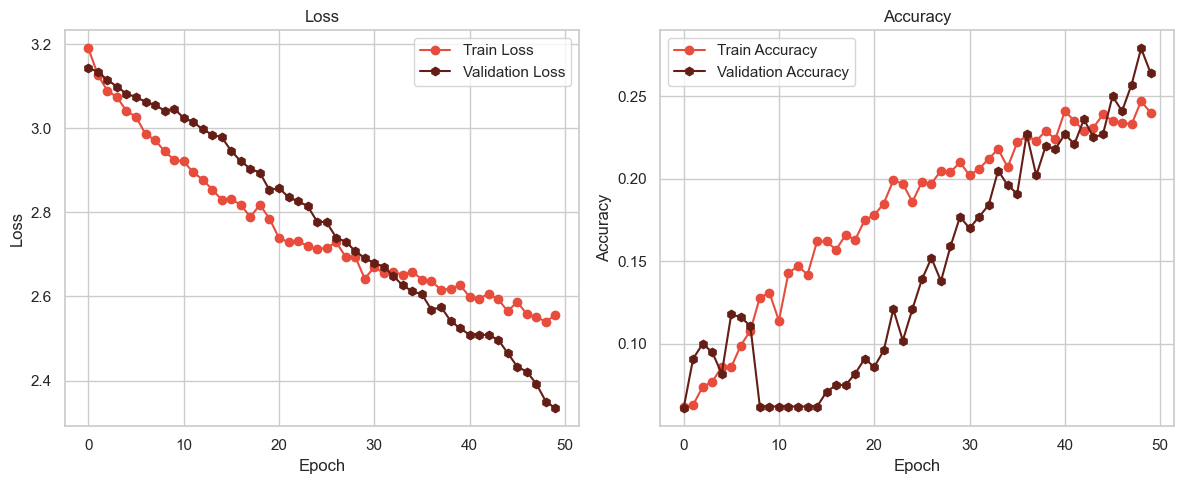

In [70]:
def plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies, save_path):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, color="#E74C3C", label='Train Loss', marker='o')
    plt.plot(val_losses, color="#641E15", label='Validation Loss', marker='h')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, color="#E74C3C", label='Train Accuracy', marker='o')
    plt.plot(val_accuracies, color="#641E15", label='Validation Accuracy', marker='h')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    
plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies, f'plots/{exp_name}_accuracy_and_Loss.png')

In [71]:
precision, recall, f1 = letter_classifier.evaluate(test_loader)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

Precision: 0.337
Recall: 0.203
F1 Score: 0.191


C:\Users\orazi\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


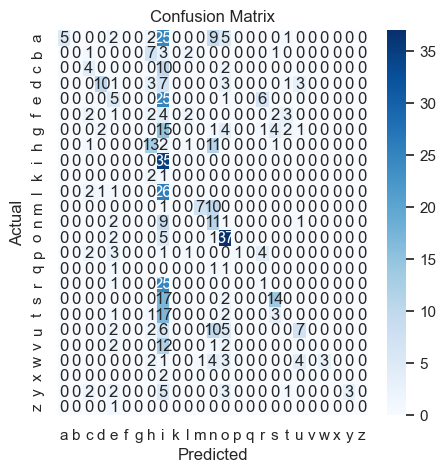

In [72]:
def print_confusion_matrix(conf_matrix, class_names, file_path=None):
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax, xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    if file_path:
        plt.savefig(file_path)
    plt.show()

cm = letter_classifier.confusion_matrix(test_loader) 
class_names = [chr(i) for i in range(ord('a'), ord('z') + 1) if chr(i) != 'j']

print_confusion_matrix(cm, class_names, f'plots/{exp_name}_confusion_matrix.png')

AUC per la classe a: 0.249
AUC per la classe b: 0.206
AUC per la classe c: 0.527
AUC per la classe d: 0.708
AUC per la classe e: 0.356
AUC per la classe f: 0.182
AUC per la classe g: 0.345
AUC per la classe h: 0.527
AUC per la classe i: 0.366
AUC per la classe k: 0.058
AUC per la classe l: 0.243
AUC per la classe m: 0.781
AUC per la classe n: 0.248
AUC per la classe o: 0.677
AUC per la classe p: 0.516
AUC per la classe q: 0.018
AUC per la classe r: 0.171
AUC per la classe s: 0.443
AUC per la classe t: 0.110
AUC per la classe u: 0.353
AUC per la classe v: 0.129
AUC per la classe w: 0.442
AUC per la classe x: 0.006
AUC per la classe y: 0.480
AUC per la classe z: 0.008


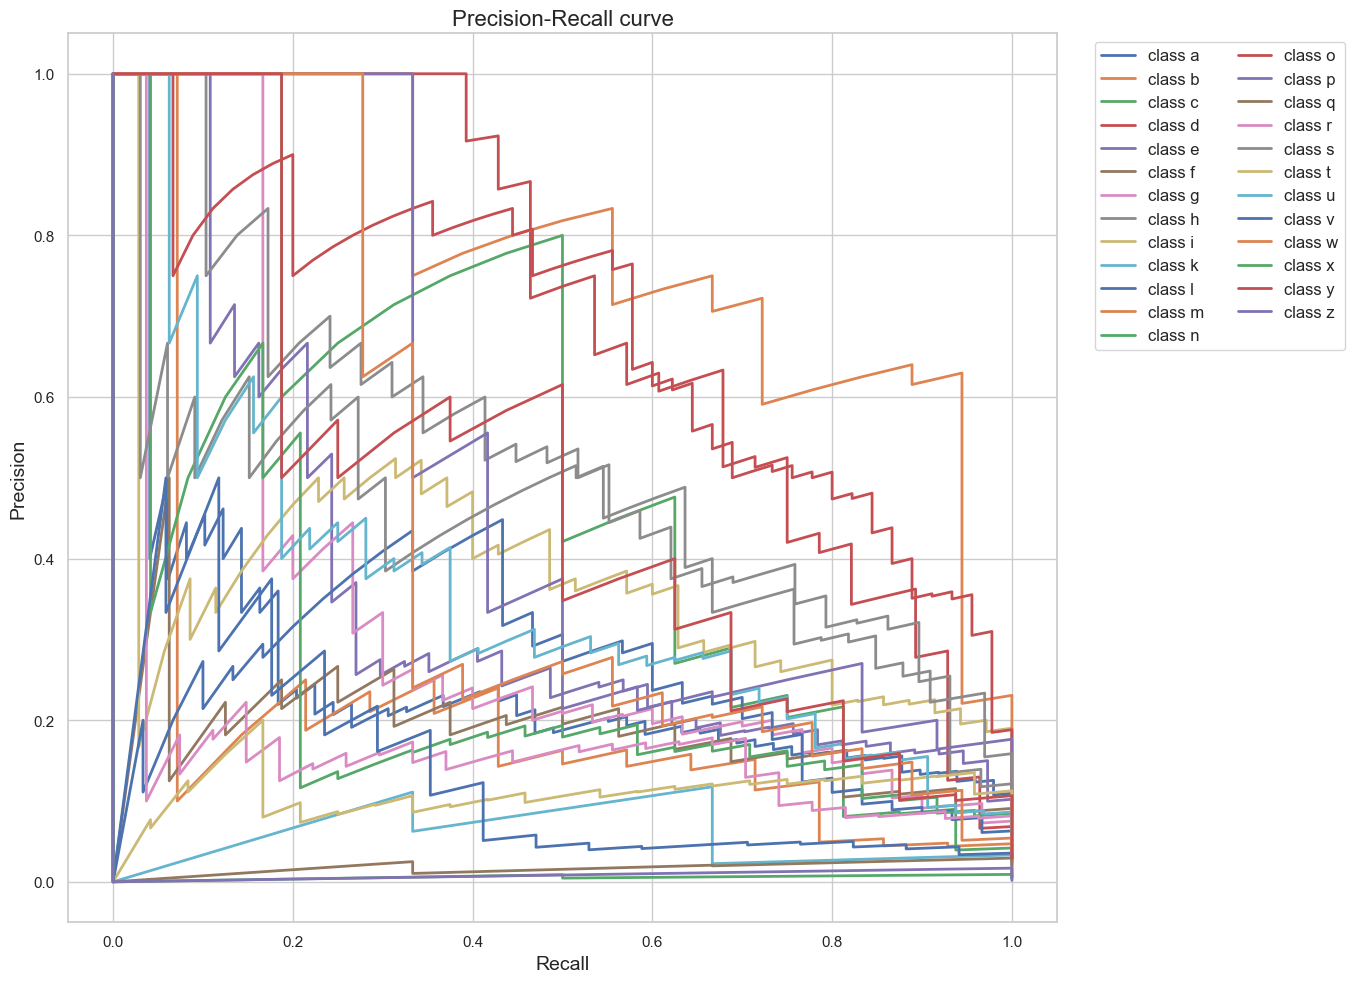

In [73]:
letter_classifier.plot_precision_recall_curve(test_loader, f'plots/{exp_name}_prec_rec_curve.png')
# la classe Scissors infatti ha una performance peggiore rispetto alle altre due classi.

## Comparison with Noted Models in the Literature

In [5]:
from torchvision.models import alexnet, vgg16, googlenet, resnet18, squeezenet1_0, AlexNet_Weights, VGG16_Weights, GoogLeNet_Weights, ResNet18_Weights, SqueezeNet1_0_Weights

class GenericModel(LetterClassifier):

    def __init__(self, model_architecture, num_classes=25):
        super(GenericModel, self).__init__(num_classes=num_classes)  
        self.model = self.get_model(model_architecture, num_classes)
        self.device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")  
        self.model.to(self.device)

    def get_model(self, model_architecture, num_classes):
        if model_architecture == 'alexnet':
            model = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
            model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        elif model_architecture == 'vgg':
            model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
            model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        elif model_architecture == 'googlenet':
            model = googlenet(weights=GoogLeNet_Weights.DEFAULT)
            model.fc = nn.Linear(model.fc.in_features, num_classes)
        elif model_architecture == 'resnet':
            model = resnet18(weights=ResNet18_Weights.DEFAULT)
            model.fc = nn.Linear(model.fc.in_features, num_classes)
        elif model_architecture == 'squeezenet':
            model = squeezenet1_0(weights=SqueezeNet1_0_Weights.DEFAULT)
            model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        else:
            raise ValueError(f"Model architecture '{model_architecture}' not recognized")
        return model

## Reload datasets

In [8]:
train_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop((50, 50)), 
    transforms.RandomAffine(30),  
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Split dataset into training, testing, and validation
train_df = df_train
test_df, val_df = train_test_split(df_test, test_size=0.2, random_state=42)

train_dataset = CustomDataset(train_df, transform=train_transform, augment=False) 
val_dataset = CustomDataset(val_df, transform=val_transform)
test_dataset = CustomDataset(test_df, transform=val_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

NameError: name 'df_train' is not defined

## AlexNet

In [22]:
alexnet = GenericModel('alexnet')
print(f'The model has {alexnet.numparams()} trainable parameters')

The model has 57106265 trainable parameters


In [23]:
alexnet.eval()
with torch.no_grad():
    alexnet_test_loss, alexnet_test_accuracy = alexnet.test_model(test_loader)
    
print('\nNon fine-tuned AlexNet:')
print(f'Test Loss: {alexnet_test_loss:.3f}, Test Accuracy: {alexnet_test_accuracy:.3f}')


Non fine-tuned AlexNet:
Test Loss: 3.424, Test Accuracy: 0.018


In [24]:
lr = 0.0001 
momentum = 0.9
weight_decay = 0.01 
exp_name = 'alexnet_experiment'
'''
alexnet_train_losses, alexnet_train_accuracies, alexnet_val_losses, alexnet_val_accuracies = alexnet.train_model(train_loader, 
                                                                                                                 val_loader,
                                                                                                                 exp_name=exp_name, 
                                                                                                                 epochs=20,
                                                                                                                 lr=lr,
                                                                                                                 momentum=momentum,
                                                                                                                 weight_decay=weight_decay)
'''

'\nalexnet_train_losses, alexnet_train_accuracies, alexnet_val_losses, alexnet_val_accuracies = alexnet.train_model(train_loader, \n                                                                                                                 val_loader,\n                                                                                                                 exp_name=exp_name, \n                                                                                                                 epochs=20,\n                                                                                                                 lr=lr,\n                                                                                                                 momentum=momentum,\n                                                                                                                 weight_decay=weight_decay)\n'

In [43]:
exp_name = 'alexnet_experiment'
alexnet.eval()

with torch.no_grad():
    alexnet_test_loss, alexnet_test_accuracy = alexnet.test_model(test_loader)

test_error = alexnet.test_error(test_loader)

# Carica i metrics
metrics_file_path = os.path.join('metrics', f'{exp_name}_metrics.pkl')
with open(metrics_file_path, 'rb') as f:
    metrics = pickle.load(f)

# Aggiorna i metrics con i valori più recenti
metrics['test_loss'] = alexnet_test_loss
metrics['test_accuracy'] = alexnet_test_accuracy
metrics['test_error'] = test_error

# Salva i metrics aggiornati
with open(metrics_file_path, 'wb') as f:
    pickle.dump(metrics, f)

print("Metrics updated and saved successfully")

# Carica i pesi del modello
model_weights_path = os.path.join('models', f'{exp_name}.pth')
model_weights = torch.load(model_weights_path)
model_weights = {'model.' + k if not k.startswith('model.') else k: v for k, v in model_weights.items()}
alexnet.load_state_dict(model_weights, strict=False)
print("Model loaded successfully")

# Ricarica i metrics
with open(metrics_file_path, 'rb') as f:
    metrics = pickle.load(f)
print("Metrics loaded successfully\n")

print('Fine-tuned AlexNet:')

# Assicurati che i valori delle metriche siano numeri singoli
train_loss = metrics['train_loss'] if isinstance(metrics['train_loss'], (int, float)) else metrics['train_loss'][-1]
train_accuracy = metrics['train_accuracy'] if isinstance(metrics['train_accuracy'], (int, float)) else metrics['train_accuracy'][-1]
val_loss = metrics['val_loss'] if isinstance(metrics['val_loss'], (int, float)) else metrics['val_loss'][-1]
val_accuracy = metrics['val_accuracy'] if isinstance(metrics['val_accuracy'], (int, float)) else metrics['val_accuracy'][-1]
test_loss = metrics['test_loss'] if isinstance(metrics['test_loss'], (int, float)) else metrics['test_loss'][-1]
test_accuracy = metrics['test_accuracy'] if isinstance(metrics['test_accuracy'], (int, float)) else metrics['test_accuracy'][-1]

print(f"Train Loss: {round(float(train_loss), 3)}")
print(f"Train Accuracy: {round(float(train_accuracy), 3)}\n")
print(f"Validation Loss: {round(float(val_loss), 3)}")
print(f"Validation Accuracy: {round(float(val_accuracy), 3)}\n")
print(f"Test Loss: {round(float(test_loss), 3)}")
print(f"Test Accuracy: {round(float(test_accuracy), 3)}")

Metrics updated and saved successfully
Model loaded successfully
Metrics loaded successfully

Fine-tuned AlexNet:
Train Loss: 2.023
Train Accuracy: 0.382

Validation Loss: 1.359
Validation Accuracy: 0.622

Test Loss: 1.407
Test Accuracy: 0.605


C:\Users\orazi\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.513
Recall: 0.499
F1 Score: 0.482


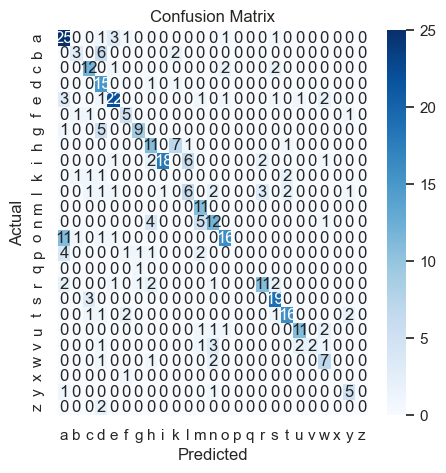

AUC per la classe a: 0.742
AUC per la classe b: 0.690
AUC per la classe c: 0.639
AUC per la classe d: 0.646
AUC per la classe e: 0.688
AUC per la classe f: 0.585
AUC per la classe g: 0.730
AUC per la classe h: 0.561
AUC per la classe i: 0.911
AUC per la classe k: 0.040
AUC per la classe l: 0.395
AUC per la classe m: 0.952
AUC per la classe n: 0.588
AUC per la classe o: 0.738
AUC per la classe p: 0.427
AUC per la classe q: 0.167
AUC per la classe r: 0.471
AUC per la classe s: 0.847
AUC per la classe t: 0.809
AUC per la classe u: 0.856
AUC per la classe v: 0.687
AUC per la classe w: 0.633
AUC per la classe x: 0.006
AUC per la classe y: 0.709
AUC per la classe z: 0.020


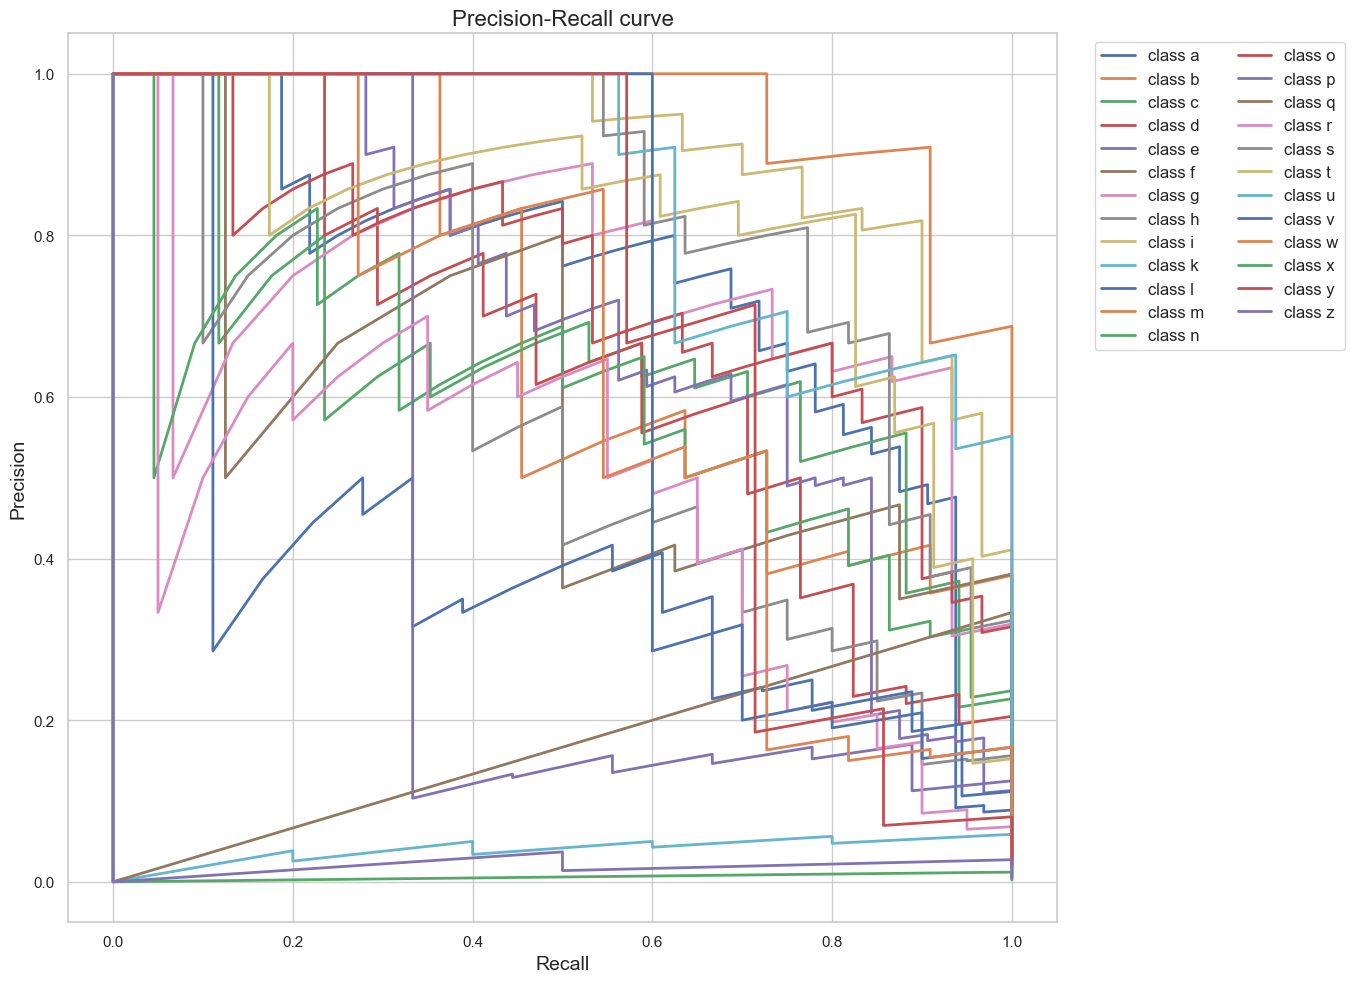

In [28]:
precision, recall, f1 = alexnet.evaluate(test_loader)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

cm = alexnet.confusion_matrix(test_loader) 
class_names = [chr(i) for i in range(ord('a'), ord('z') + 1) if chr(i) != 'j']  

print_confusion_matrix(cm, class_names, f'plots/{exp_name}_confusion_matrix.png')

alexnet.plot_precision_recall_curve(test_loader, f'plots/{exp_name}_prec_rec_curve.png')

## VGG

In [29]:
vgg = GenericModel('vgg')
print(f'The model has {vgg.numparams()} trainable parameters')

The model has 134362969 trainable parameters


In [51]:
vgg.eval()
with torch.no_grad():
    vgg_test_loss, vgg_test_accuracy = vgg.test_model(test_loader)
    
print('\nNon fine-tuned vgg:')
print(f'Test Loss: {vgg_test_loss:.3f}, Test Accuracy: {vgg_test_accuracy:.3f}')


Non fine-tuned vgg:
Test Loss: 3.280, Test Accuracy: 0.046


In [52]:
exp_name = 'vgg_experiment'

'''
vgg_train_losses, vgg_train_accuracies, vgg_val_losses, vgg_val_accuracies = vgg.train_model(train_loader, 
                                                                                             val_loader,
                                                                                             exp_name=exp_name, 
                                                                                             epochs=20,
                                                                                             lr=lr,
                                                                                             momentum=momentum,
                                                                                             weight_decay=weight_decay)
'''

[Epoch 1/20]
Train Loss: 3.111, Train Accuracy: 0.079 | Val Loss: 2.977, Val Accuracy: 0.194

[Epoch 2/20]
Train Loss: 2.852, Train Accuracy: 0.166 | Val Loss: 2.717, Val Accuracy: 0.163

[Epoch 3/20]
Train Loss: 2.579, Train Accuracy: 0.238 | Val Loss: 2.229, Val Accuracy: 0.296

[Epoch 4/20]
Train Loss: 2.366, Train Accuracy: 0.281 | Val Loss: 1.910, Val Accuracy: 0.449

[Epoch 5/20]
Train Loss: 2.173, Train Accuracy: 0.345 | Val Loss: 1.728, Val Accuracy: 0.439

[Epoch 6/20]
Train Loss: 2.058, Train Accuracy: 0.373 | Val Loss: 1.376, Val Accuracy: 0.541

[Epoch 7/20]
Train Loss: 1.923, Train Accuracy: 0.411 | Val Loss: 1.257, Val Accuracy: 0.622

[Epoch 8/20]
Train Loss: 1.764, Train Accuracy: 0.456 | Val Loss: 1.024, Val Accuracy: 0.694

[Epoch 9/20]
Train Loss: 1.672, Train Accuracy: 0.491 | Val Loss: 0.943, Val Accuracy: 0.704

[Epoch 10/20]
Train Loss: 1.619, Train Accuracy: 0.514 | Val Loss: 0.894, Val Accuracy: 0.673

[Epoch 11/20]
Train Loss: 1.570, Train Accuracy: 0.519 | Va

In [53]:
exp_name = 'vgg_experiment'
vgg.eval()

with torch.no_grad():
    vgg_test_loss, vgg_test_accuracy = vgg.test_model(test_loader)

test_error = vgg.test_error(test_loader)

# Carica i metrics
metrics_file_path = os.path.join('metrics', f'{exp_name}_metrics.pkl')
with open(metrics_file_path, 'rb') as f:
    metrics = pickle.load(f)

# Aggiorna i metrics con i valori più recenti
metrics['test_loss'] = vgg_test_loss
metrics['test_accuracy'] = vgg_test_accuracy
metrics['test_error'] = test_error

# Salva i metrics aggiornati
with open(metrics_file_path, 'wb') as f:
    pickle.dump(metrics, f)

print("Metrics updated and saved successfully")

# Carica i pesi del modello
model_weights_path = os.path.join('models', f'{exp_name}.pth')
model_weights = torch.load(model_weights_path)
model_weights = {'model.' + k if not k.startswith('model.') else k: v for k, v in model_weights.items()}
vgg.load_state_dict(model_weights, strict=False)
print("Model loaded successfully")

# Ricarica i metrics
with open(metrics_file_path, 'rb') as f:
    metrics = pickle.load(f)
print("Metrics loaded successfully\n")

print('Fine-tuned vgg:')

# Assicurati che i valori delle metriche siano numeri singoli
train_loss = metrics['train_loss'] if isinstance(metrics['train_loss'], (int, float)) else metrics['train_loss'][-1]
train_accuracy = metrics['train_accuracy'] if isinstance(metrics['train_accuracy'], (int, float)) else metrics['train_accuracy'][-1]
val_loss = metrics['val_loss'] if isinstance(metrics['val_loss'], (int, float)) else metrics['val_loss'][-1]
val_accuracy = metrics['val_accuracy'] if isinstance(metrics['val_accuracy'], (int, float)) else metrics['val_accuracy'][-1]
test_loss = metrics['test_loss'] if isinstance(metrics['test_loss'], (int, float)) else metrics['test_loss'][-1]
test_accuracy = metrics['test_accuracy'] if isinstance(metrics['test_accuracy'], (int, float)) else metrics['test_accuracy'][-1]

print(f"Train Loss: {round(float(train_loss), 3)}")
print(f"Train Accuracy: {round(float(train_accuracy), 3)}\n")
print(f"Validation Loss: {round(float(val_loss), 3)}")
print(f"Validation Accuracy: {round(float(val_accuracy), 3)}\n")
print(f"Test Loss: {round(float(test_loss), 3)}")
print(f"Test Accuracy: {round(float(test_accuracy), 3)}")

Metrics updated and saved successfully
Model loaded successfully
Metrics loaded successfully

Fine-tuned vgg:
Train Loss: 1.312
Train Accuracy: 0.605

Validation Loss: 0.617
Validation Accuracy: 0.806

Test Loss: 0.705
Test Accuracy: 0.777


C:\Users\orazi\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.755
Recall: 0.726
F1 Score: 0.719


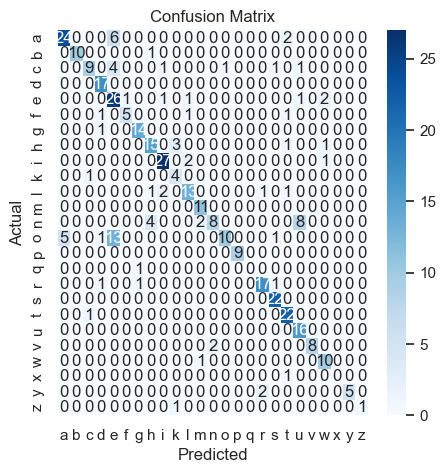

AUC per la classe a: 0.858
AUC per la classe b: 1.000
AUC per la classe c: 0.791
AUC per la classe d: 1.000
AUC per la classe e: 0.827
AUC per la classe f: 0.859
AUC per la classe g: 0.968
AUC per la classe h: 0.863
AUC per la classe i: 0.953
AUC per la classe k: 0.770
AUC per la classe l: 0.788
AUC per la classe m: 1.000
AUC per la classe n: 0.799
AUC per la classe o: 0.885
AUC per la classe p: 1.000
AUC per la classe q: 1.000
AUC per la classe r: 0.835
AUC per la classe s: 0.996
AUC per la classe t: 0.925
AUC per la classe u: 0.821
AUC per la classe v: 0.944
AUC per la classe w: 0.966
AUC per la classe x: 1.000
AUC per la classe y: 0.802
AUC per la classe z: 0.792


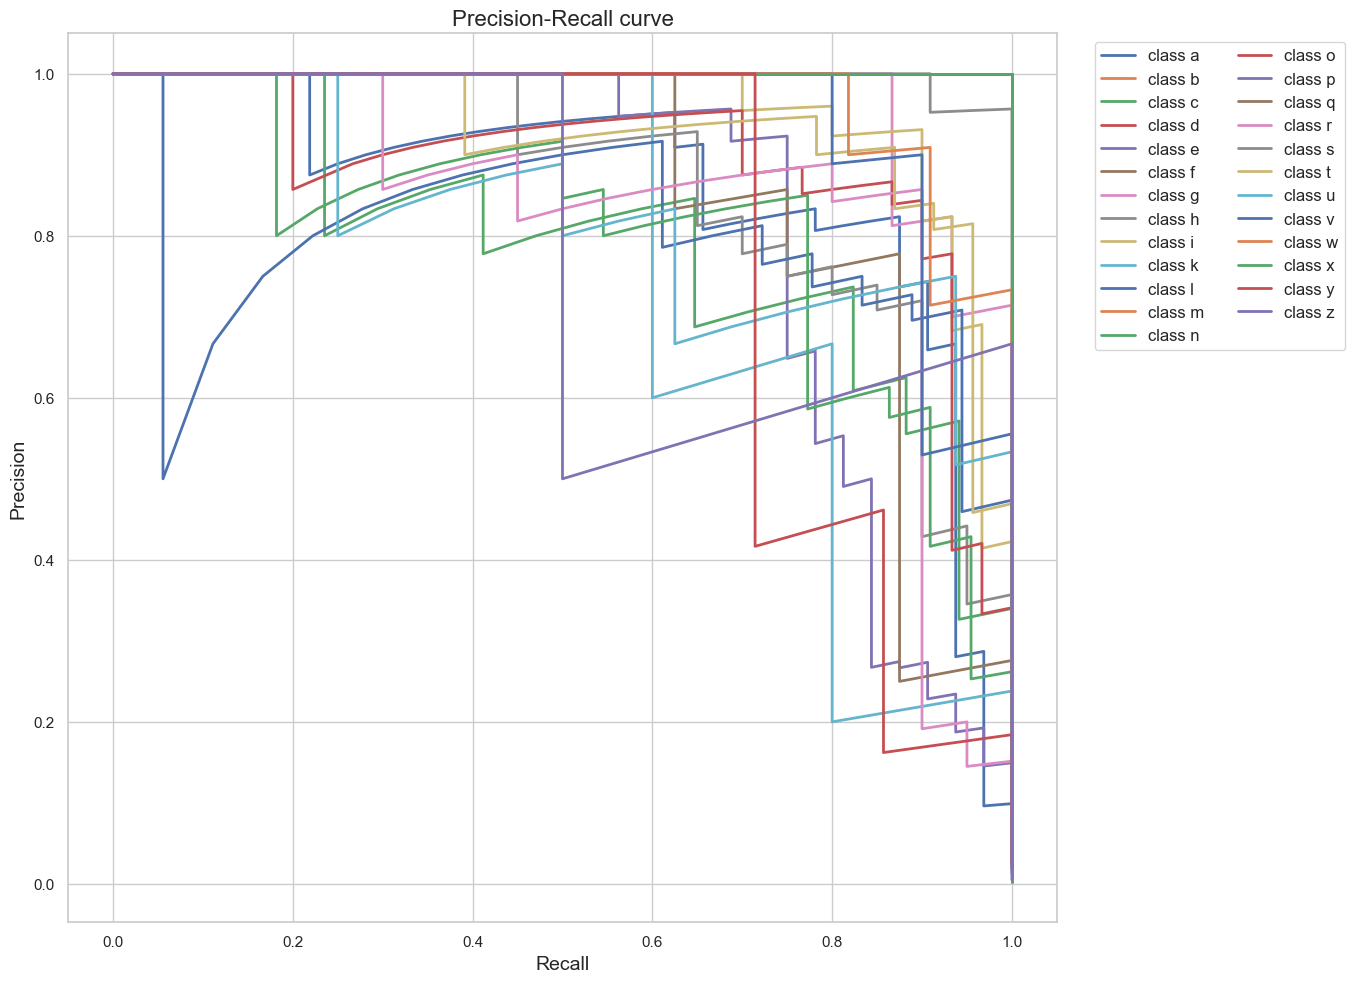

In [54]:
precision, recall, f1 = vgg.evaluate(test_loader)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

cm = vgg.confusion_matrix(test_loader) 
class_names = [chr(i) for i in range(ord('a'), ord('z') + 1) if chr(i) != 'j']

print_confusion_matrix(cm, class_names, f'plots/{exp_name}_confusion_matrix.png')

vgg.plot_precision_recall_curve(test_loader, f'plots/{exp_name}_prec_rec_curve.png')

## GoogleNet

In [30]:
googlenet = GenericModel('googlenet')
print(f'The model has {googlenet.numparams()} trainable parameters')

The model has 5625529 trainable parameters


In [31]:
googlenet.eval()
with torch.no_grad():
    googlenet_test_loss, googlenet_test_accuracy = googlenet.test_model(test_loader)
    
print('\nNon fine-tuned GoogleNet:')
print(f'Test Loss: {googlenet_test_loss:.3f}, Test Accuracy: {googlenet_test_accuracy:.3f}')


Non fine-tuned GoogleNet:
Test Loss: 3.227, Test Accuracy: 0.033


In [32]:
exp_name = 'googlenet_experiment'

'''
googlenet_train_losses, googlenet_train_accuracies, googlenet_val_losses, googlenet_val_accuracies = googlenet.train_model(train_loader, 
                                                                                             val_loader,
                                                                                             exp_name=exp_name, 
                                                                                             epochs=20,
                                                                                             lr=lr,
                                                                                             momentum=momentum,
                                                                                             weight_decay=weight_decay)
'''

'\ngooglenet_train_losses, googlenet_train_accuracies, googlenet_val_losses, googlenet_val_accuracies = googlenet.train_model(train_loader, \n                                                                                             val_loader,\n                                                                                             exp_name=exp_name, \n                                                                                             epochs=20,\n                                                                                             lr=lr,\n                                                                                             momentum=momentum,\n                                                                                             weight_decay=weight_decay)\n'

In [44]:
exp_name = 'googlenet_experiment'
googlenet.eval()

with torch.no_grad():
    googlenet_test_loss, googlenet_test_accuracy = googlenet.test_model(test_loader)

test_error = googlenet.test_error(test_loader)

# Carica i metrics
metrics_file_path = os.path.join('metrics', f'{exp_name}_metrics.pkl')
with open(metrics_file_path, 'rb') as f:
    metrics = pickle.load(f)

# Aggiorna i metrics con i valori più recenti
metrics['test_loss'] = googlenet_test_loss
metrics['test_accuracy'] = googlenet_test_accuracy
metrics['test_error'] = test_error

# Salva i metrics aggiornati
with open(metrics_file_path, 'wb') as f:
    pickle.dump(metrics, f)

print("Metrics updated and saved successfully")

# Carica i pesi del modello
model_weights_path = os.path.join('models', f'{exp_name}.pth')
model_weights = torch.load(model_weights_path)
model_weights = {'model.' + k if not k.startswith('model.') else k: v for k, v in model_weights.items()}
googlenet.load_state_dict(model_weights, strict=False)
print("Model loaded successfully")

# Ricarica i metrics
with open(metrics_file_path, 'rb') as f:
    metrics = pickle.load(f)
print("Metrics loaded successfully\n")

print('Fine-tuned GoogleNet:')

# Assicurati che i valori delle metriche siano numeri singoli
train_loss = metrics['train_loss'] if isinstance(metrics['train_loss'], (int, float)) else metrics['train_loss'][-1]
train_accuracy = metrics['train_accuracy'] if isinstance(metrics['train_accuracy'], (int, float)) else metrics['train_accuracy'][-1]
val_loss = metrics['val_loss'] if isinstance(metrics['val_loss'], (int, float)) else metrics['val_loss'][-1]
val_accuracy = metrics['val_accuracy'] if isinstance(metrics['val_accuracy'], (int, float)) else metrics['val_accuracy'][-1]
test_loss = metrics['test_loss'] if isinstance(metrics['test_loss'], (int, float)) else metrics['test_loss'][-1]
test_accuracy = metrics['test_accuracy'] if isinstance(metrics['test_accuracy'], (int, float)) else metrics['test_accuracy'][-1]

print(f"Train Loss: {round(float(train_loss), 3)}")
print(f"Train Accuracy: {round(float(train_accuracy), 3)}\n")
print(f"Validation Loss: {round(float(val_loss), 3)}")
print(f"Validation Accuracy: {round(float(val_accuracy), 3)}\n")
print(f"Test Loss: {round(float(test_loss), 3)}")
print(f"Test Accuracy: {round(float(test_accuracy), 3)}")

Metrics updated and saved successfully
Model loaded successfully
Metrics loaded successfully

Fine-tuned GoogleNet:
Train Loss: 2.946
Train Accuracy: 0.157

Validation Loss: 3.002
Validation Accuracy: 0.122

Test Loss: 2.908
Test Accuracy: 0.141


C:\Users\orazi\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.106
Recall: 0.082
F1 Score: 0.070


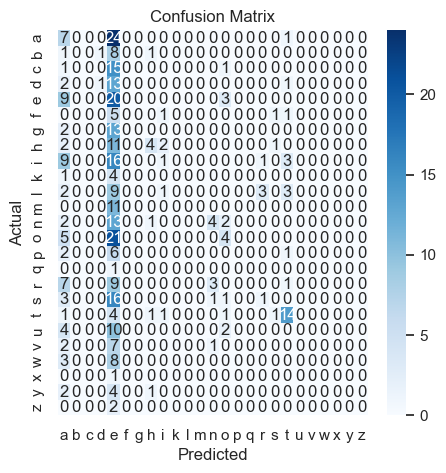

AUC per la classe a: 0.132
AUC per la classe b: 0.077
AUC per la classe c: 0.059
AUC per la classe d: 0.296
AUC per la classe e: 0.178
AUC per la classe f: 0.042
AUC per la classe g: 0.164
AUC per la classe h: 0.143
AUC per la classe i: 0.411
AUC per la classe k: 0.017
AUC per la classe l: 0.182
AUC per la classe m: 0.325
AUC per la classe n: 0.320
AUC per la classe o: 0.228
AUC per la classe p: 0.025
AUC per la classe q: 0.083
AUC per la classe r: 0.124
AUC per la classe s: 0.344
AUC per la classe t: 0.486
AUC per la classe u: 0.053
AUC per la classe v: 0.028
AUC per la classe w: 0.070
AUC per la classe x: 0.012
AUC per la classe y: 0.042
AUC per la classe z: 0.010


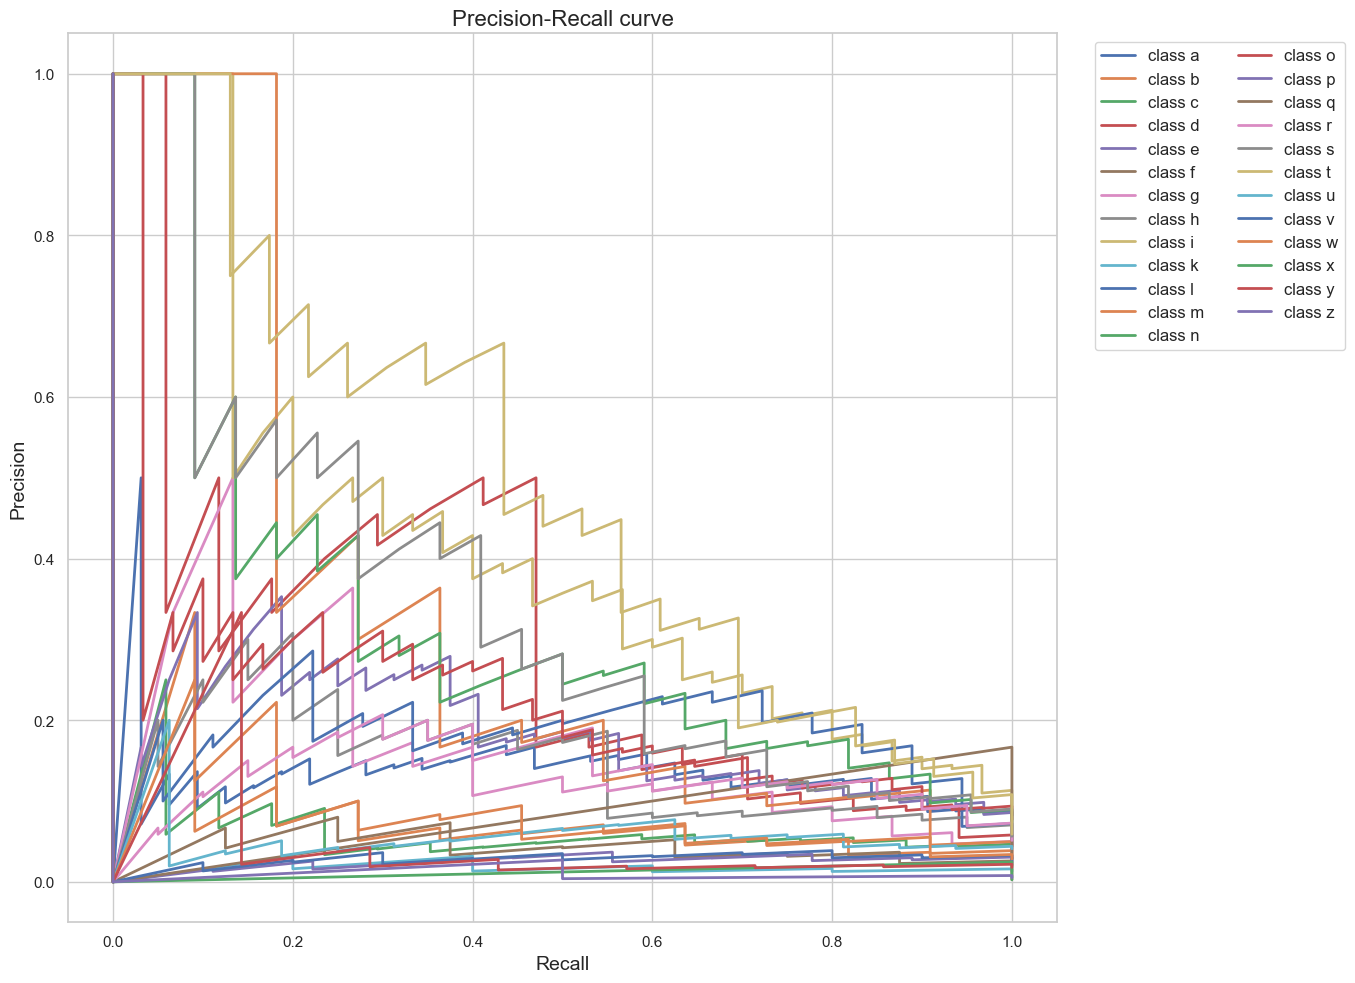

In [35]:
precision, recall, f1 = googlenet.evaluate(test_loader)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

cm = googlenet.confusion_matrix(test_loader) 
class_names = [chr(i) for i in range(ord('a'), ord('z') + 1) if chr(i) != 'j']

print_confusion_matrix(cm, class_names, f'plots/{exp_name}_confusion_matrix.png')

googlenet.plot_precision_recall_curve(test_loader, f'plots/{exp_name}_prec_rec_curve.png')

## ResNet

In [36]:
resnet = GenericModel('resnet')
print(f'The model has {resnet.numparams()} trainable parameters')

The model has 11189337 trainable parameters


In [37]:
resnet.eval()
with torch.no_grad():
    resnet_test_loss, resnet_test_accuracy = resnet.test_model(test_loader)
    
print('\nNon fine-tuned SqueezeNet:')
print(f'Test Loss: {resnet_test_loss:.3f}, Test Accuracy: {resnet_test_accuracy:.3f}')


Non fine-tuned SqueezeNet:
Test Loss: 3.326, Test Accuracy: 0.041


In [38]:
lr = 0.001 
momentum = 0.9
weight_decay = 0.001 
exp_name = 'resnet_experiment'

'''
resnet_train_losses, resnet_train_accuracies, resnet_val_losses, resnet_val_accuracies = resnet.train_model(train_loader, 
                                                                                             val_loader,
                                                                                             exp_name=exp_name, 
                                                                                             epochs=20,
                                                                                             lr=lr,
                                                                                             momentum=momentum,
                                                                                             weight_decay=weight_decay)
'''

'\nresnet_train_losses, resnet_train_accuracies, resnet_val_losses, resnet_val_accuracies = resnet.train_model(train_loader, \n                                                                                             val_loader,\n                                                                                             exp_name=exp_name, \n                                                                                             epochs=20,\n                                                                                             lr=lr,\n                                                                                             momentum=momentum,\n                                                                                             weight_decay=weight_decay)\n'

In [45]:
exp_name = 'resnet_experiment'
resnet.eval()

with torch.no_grad():
    resnet_test_loss, resnet_test_accuracy = resnet.test_model(test_loader)

test_error = resnet.test_error(test_loader)

# Carica i metrics
metrics_file_path = os.path.join('metrics', f'{exp_name}_metrics.pkl')
with open(metrics_file_path, 'rb') as f:
    metrics = pickle.load(f)

# Aggiorna i metrics con i valori più recenti
metrics['test_loss'] = resnet_test_loss
metrics['test_accuracy'] = resnet_test_accuracy
metrics['test_error'] = test_error

# Salva i metrics aggiornati
with open(metrics_file_path, 'wb') as f:
    pickle.dump(metrics, f)

print("Metrics updated and saved successfully")

# Carica i pesi del modello
model_weights_path = os.path.join('models', f'{exp_name}.pth')
model_weights = torch.load(model_weights_path)
model_weights = {'model.' + k if not k.startswith('model.') else k: v for k, v in model_weights.items()}
resnet.load_state_dict(model_weights, strict=False)
print("Model loaded successfully")

# Ricarica i metrics
with open(metrics_file_path, 'rb') as f:
    metrics = pickle.load(f)
print("Metrics loaded successfully\n")

print('Fine-tuned ResNet:')

# Assicurati che i valori delle metriche siano numeri singoli
train_loss = metrics['train_loss'] if isinstance(metrics['train_loss'], (int, float)) else metrics['train_loss'][-1]
train_accuracy = metrics['train_accuracy'] if isinstance(metrics['train_accuracy'], (int, float)) else metrics['train_accuracy'][-1]
val_loss = metrics['val_loss'] if isinstance(metrics['val_loss'], (int, float)) else metrics['val_loss'][-1]
val_accuracy = metrics['val_accuracy'] if isinstance(metrics['val_accuracy'], (int, float)) else metrics['val_accuracy'][-1]
test_loss = metrics['test_loss'] if isinstance(metrics['test_loss'], (int, float)) else metrics['test_loss'][-1]
test_accuracy = metrics['test_accuracy'] if isinstance(metrics['test_accuracy'], (int, float)) else metrics['test_accuracy'][-1]

print(f"Train Loss: {round(float(train_loss), 3)}")
print(f"Train Accuracy: {round(float(train_accuracy), 3)}\n")
print(f"Validation Loss: {round(float(val_loss), 3)}")
print(f"Validation Accuracy: {round(float(val_accuracy), 3)}\n")
print(f"Test Loss: {round(float(test_loss), 3)}")
print(f"Test Accuracy: {round(float(test_accuracy), 3)}")


Metrics updated and saved successfully
Model loaded successfully
Metrics loaded successfully

Fine-tuned ResNet:
Train Loss: 1.307
Train Accuracy: 0.618

Validation Loss: 0.737
Validation Accuracy: 0.786

Test Loss: 0.707
Test Accuracy: 0.81


C:\Users\orazi\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.670
Recall: 0.700
F1 Score: 0.676


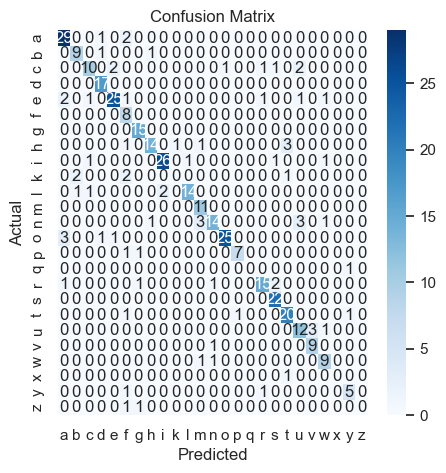

AUC per la classe a: 0.919
AUC per la classe b: 0.964
AUC per la classe c: 0.756
AUC per la classe d: 1.000
AUC per la classe e: 0.920
AUC per la classe f: 0.677
AUC per la classe g: 0.986
AUC per la classe h: 0.816
AUC per la classe i: 0.955
AUC per la classe k: 0.361
AUC per la classe l: 0.830
AUC per la classe m: 1.000
AUC per la classe n: 0.882
AUC per la classe o: 0.971
AUC per la classe p: 0.975
AUC per la classe q: 0.024
AUC per la classe r: 0.932
AUC per la classe s: 0.991
AUC per la classe t: 0.940
AUC per la classe u: 0.803
AUC per la classe v: 0.859
AUC per la classe w: 0.845
AUC per la classe x: 0.250
AUC per la classe y: 0.902
AUC per la classe z: 1.000


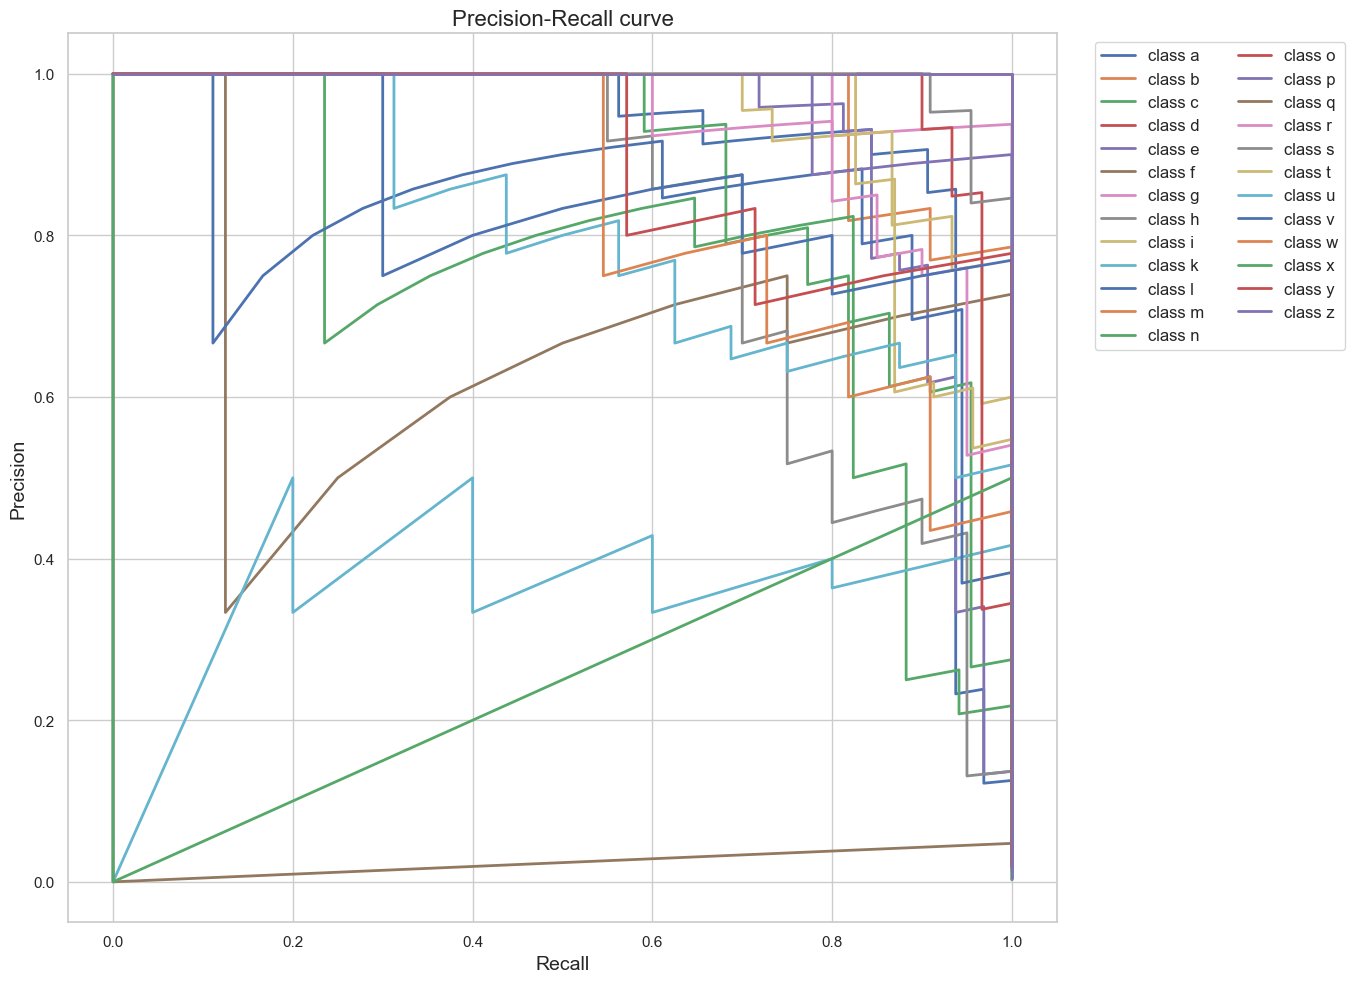

In [40]:
precision, recall, f1 = resnet.evaluate(test_loader)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

cm = resnet.confusion_matrix(test_loader) 
class_names = [chr(i) for i in range(ord('a'), ord('z') + 1) if chr(i) != 'j']  

print_confusion_matrix(cm, class_names, f'plots/{exp_name}_confusion_matrix.png')

resnet.plot_precision_recall_curve(test_loader, f'plots/{exp_name}_prec_rec_curve.png')

## SqueezeNet

In [6]:
squeezenet = GenericModel('squeezenet')
print(f'The model has {squeezenet.numparams()} trainable parameters')

The model has 748249 trainable parameters


In [ ]:
squeezenet.eval()
with torch.no_grad():
    squeezenet_test_loss, squeezenet_test_accuracy = squeezenet.test_model(test_loader)
    
print('\nNon fine-tuned SqueezeNet:')
print(f'Test Loss: {squeezenet_test_loss:.3f}, Test Accuracy: {squeezenet_test_accuracy:.3f}')


Non fine-tuned SqueezeNet:
Test Loss: 3.758, Test Accuracy: 0.021


In [49]:
lr = 0.001 
momentum = 0.9
weight_decay = 0.001 
exp_name = 'squeezenet_experiment'

'''
squeezenet_train_losses, squeezenet_train_accuracies, squeezenet_val_losses, squeezenet_val_accuracies = squeezenet.train_model(train_loader, 
                                                                                             val_loader,
                                                                                             exp_name=exp_name, 
                                                                                             epochs=20,
                                                                                             lr=lr,
                                                                                             momentum=momentum,
                                                                                             weight_decay=weight_decay)
'''

'\nsqueezenet_train_losses, squeezenet_train_accuracies, squeezenet_val_losses, squeezenet_val_accuracies = squeezenet.train_model(train_loader, \n                                                                                             val_loader,\n                                                                                             exp_name=exp_name, \n                                                                                             epochs=20,\n                                                                                             lr=lr,\n                                                                                             momentum=momentum,\n                                                                                             weight_decay=weight_decay)\n'

In [7]:
exp_name = 'squeezenet_experiment'
squeezenet.eval()

with torch.no_grad():
    squeezenet_test_loss, squeezenet_test_accuracy = squeezenet.test_model(test_loader)

test_error = squeezenet.test_error(test_loader)

# Carica i metrics
metrics_file_path = os.path.join('metrics', f'{exp_name}_metrics.pkl')
with open(metrics_file_path, 'rb') as f:
    metrics = pickle.load(f)

# Aggiorna i metrics con i valori più recenti
metrics['test_loss'] = squeezenet_test_loss
metrics['test_accuracy'] = squeezenet_test_accuracy
metrics['test_error'] = test_error

# Salva i metrics aggiornati
with open(metrics_file_path, 'wb') as f:
    pickle.dump(metrics, f)

print("Metrics updated and saved successfully")

# Carica i pesi del modello
model_weights_path = os.path.join('models', f'{exp_name}.pth')
model_weights = torch.load(model_weights_path)
model_weights = {'model.' + k if not k.startswith('model.') else k: v for k, v in model_weights.items()}
squeezenet.load_state_dict(model_weights, strict=False)
print("Model loaded successfully")

# Ricarica i metrics
with open(metrics_file_path, 'rb') as f:
    metrics = pickle.load(f)
print("Metrics loaded successfully\n")

print('Fine-tuned SqueezeNet:')

# Assicurati che i valori delle metriche siano numeri singoli
train_loss = metrics['train_loss'] if isinstance(metrics['train_loss'], (int, float)) else metrics['train_loss'][-1]
train_accuracy = metrics['train_accuracy'] if isinstance(metrics['train_accuracy'], (int, float)) else metrics['train_accuracy'][-1]
val_loss = metrics['val_loss'] if isinstance(metrics['val_loss'], (int, float)) else metrics['val_loss'][-1]
val_accuracy = metrics['val_accuracy'] if isinstance(metrics['val_accuracy'], (int, float)) else metrics['val_accuracy'][-1]
test_loss = metrics['test_loss'] if isinstance(metrics['test_loss'], (int, float)) else metrics['test_loss'][-1]
test_accuracy = metrics['test_accuracy'] if isinstance(metrics['test_accuracy'], (int, float)) else metrics['test_accuracy'][-1]

print(f"Train Loss: {round(float(train_loss), 3)}")
print(f"Train Accuracy: {round(float(train_accuracy), 3)}\n")
print(f"Validation Loss: {round(float(val_loss), 3)}")
print(f"Validation Accuracy: {round(float(val_accuracy), 3)}\n")
print(f"Test Loss: {round(float(test_loss), 3)}")
print(f"Test Accuracy: {round(float(test_accuracy), 3)}")

NameError: name 'test_loader' is not defined

C:\Users\orazi\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.590
Recall: 0.544
F1 Score: 0.531


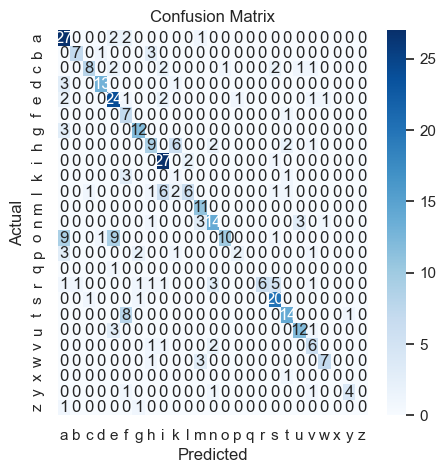

AUC per la classe a: 0.849
AUC per la classe b: 0.851
AUC per la classe c: 0.718
AUC per la classe d: 0.967
AUC per la classe e: 0.804
AUC per la classe f: 0.377
AUC per la classe g: 0.874
AUC per la classe h: 0.588
AUC per la classe i: 0.904
AUC per la classe k: 0.078
AUC per la classe l: 0.671
AUC per la classe m: 1.000
AUC per la classe n: 0.723
AUC per la classe o: 0.789
AUC per la classe p: 0.552
AUC per la classe q: 0.010
AUC per la classe r: 0.794
AUC per la classe s: 0.890
AUC per la classe t: 0.858
AUC per la classe u: 0.809
AUC per la classe v: 0.723
AUC per la classe w: 0.734
AUC per la classe x: 0.167
AUC per la classe y: 0.666
AUC per la classe z: 0.417


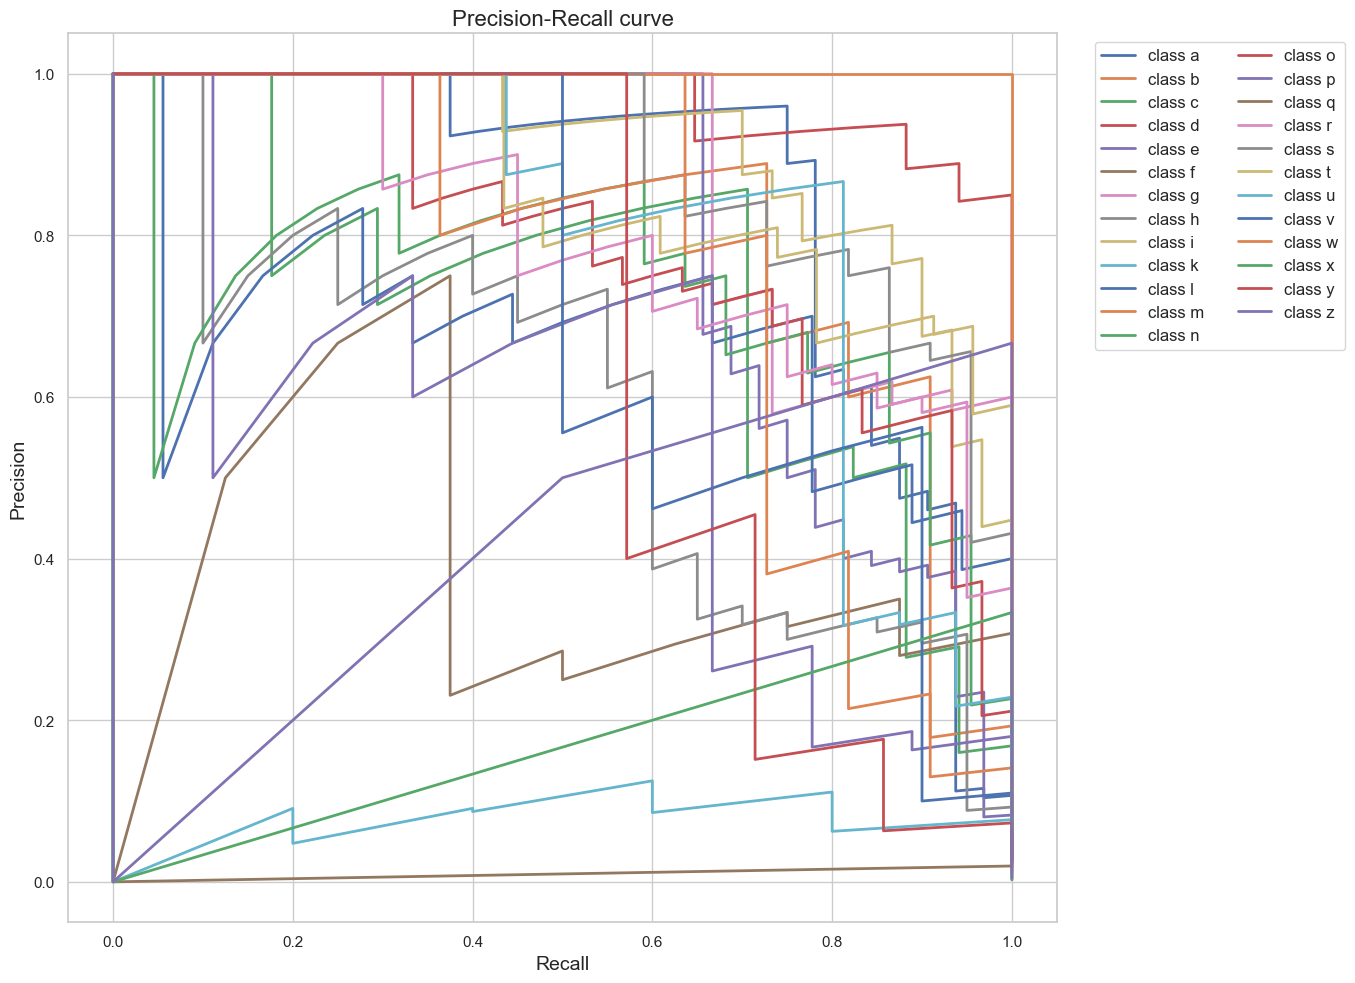

In [44]:
precision, recall, f1 = squeezenet.evaluate(test_loader)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

cm = squeezenet.confusion_matrix(test_loader) 
class_names = [chr(i) for i in range(ord('a'), ord('z') + 1) if chr(i) != 'j']  

print_confusion_matrix(cm, class_names, f'plots/{exp_name}_confusion_matrix.png')

squeezenet.plot_precision_recall_curve(test_loader, f'plots/{exp_name}_prec_rec_curve.png')